In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

READ DATA

In [23]:
def read_data(verbose=False):

    data = pd.read_csv("all_stocks_5yr.csv")
    df = data[["date", "Name", "close"]]

    prices = df.pivot(index="date", columns="Name", values="close")
    prices = prices.dropna(axis=1)

    # with open("prices.txt", "w") as f:
    #     f.write(prices.to_string())
    #     f.close()

    returns = prices.pct_change().dropna()
    # with open("rendements.txt", "w") as f:
    #     f.write(returns.to_string())
    #     f.close()


    X = returns.values
    mu = returns.mean().values
    Sigma = returns.cov().values
   
    


    if verbose:
        print("X shape =", X.shape)
        print("mu shape =", mu.shape)
        print("Sigma shape =", Sigma.shape)
    
    return X, mu, Sigma



PROJECTION OPERATOR

In [24]:
def projection_on_simplex(v):
    """
    Project a vector v onto the simplex:
        Δ = { w >= 0, sum(w) = 1 }
    """
   
    u = sorted(v, reverse=True)
    cumulative_sum = np.cumsum(u)

    thetas = (cumulative_sum - 1) / (np.arange(1, len(v) + 1))
    k = np.where(u - thetas > 0)[0].max()

    theta = (cumulative_sum[k] - 1) / (k + 1)
    w = np.maximum(v - theta, 0)

    return w

def test(): 
    v = np.array([0.9, 0.9, 0.2])
    v2 = -1 * v

    print("w1 : ", projection_on_simplex(v))
    print("w2 : ", projection_on_simplex(v2))

***SMOOTH MEAN-VARIACE OBJECTIVE***



In [25]:
def obj_f_Smooth(w, Sigma, mu, lam):

    return 0.5 * w.T @ Sigma @ w -lam * (mu @ w) 

***PROJECTED GRADIENT DESCENT***


In [35]:
def projected_gradient_method(lam,Sigma, mu, max_iter=50000, tol= 1e-8, plot=False): 

    n = Sigma.shape[0]  
    w = np.ones(n) / n  
    L= np.max(np.linalg.eigvals(Sigma))
    step_size = 1 / L
       
   
    if plot:
        obj_values = []
    for k in tqdm(range(max_iter)):

        if plot:
            obj_values.append(obj_f_Smooth(w, Sigma, mu, lam))

    #Compute the gradient
        g = Sigma@w - lam * mu
    #Gradient step and projection
        w_new = projection_on_simplex(w - step_size * g)
        
        if (np.linalg.norm(w_new - w) < tol):
            print(f"Converged in {k} iterations.")
            w = w_new
            break

        w = w_new

    with open("values_PDG.txt", "w") as f:
        f.write(str(obj_values))
        f.close()


    if plot:
        plt.plot(obj_values)
        plt.xlabel("Iteration")
        
       # plt.yscale("log")
        plt.ylabel("Objective value (log scale)")
        plt.title("Convergence of Projected gradient Method")
        plt.show()
    
    return w

X shape = (1258, 470)
mu shape = (470,)
Sigma shape = (470, 470)


 62%|██████▏   | 932/1500 [00:00<00:00, 1488.84it/s]


Converged in 932 iterations.


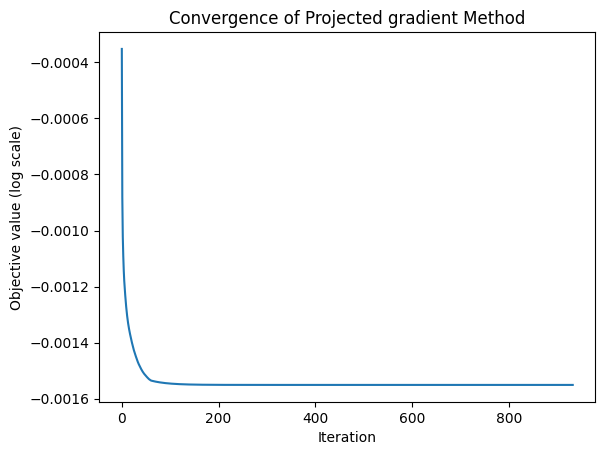

Optimal weights: [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.   

In [ ]:
X, mu, Sigma = read_data(verbose=True)
lam = 0.2   # TO ADJUCT ACCORDING IF WNT A RISKY OR LESS RISKY PORTFOLIO

w = projected_gradient_method(lam, Sigma, mu,max_iter=1500, tol=1e-8, plot=True)
print("Optimal weights:", w)
print("Sum of weights:", np.sum(w))
print("Converged objective value:", obj_f_Smooth(w, Sigma, mu, lam))

***Projected Subgradient Method***

In [ ]:

def obj_f_nonSmooth(w, wprev, Sigma, mu, lam, c):

    return 0.5 * w.T @ Sigma @ w -lam * (mu @ w) + \
            c * np.sum(np.abs(w - wprev))

def projected_subgradient_method(lam, c, Sigma, mu, wprev, alpha0=0.1, max_iter=50000, tol= 1e-8, plot=False): 

    w = wprev
    k = 0
    if plot:
        obj_values = []
    for k in tqdm(range(max_iter)):

        if plot:
            obj_values.append(obj_f_nonSmooth(w, wprev, Sigma, mu, lam, c))

        g = Sigma @ w - lam * mu + c * np.sign(w - wprev)
        step_size = alpha0 / (k + 1)
        w_new = projection_on_simplex(w - step_size * g)
        
        if (np.linalg.norm(w_new - w) < tol):
            print(f"Converged in {k} iterations.")
            break

        w = w_new

    with open("values.txt", "w") as f:
        f.write(str(obj_values))
        f.close()


    if plot:
        plt.plot(obj_values)
        plt.xlabel("Iteration")
        
       # plt.yscale("log")
        plt.ylabel("Objective value (log scale)")
        plt.title("Convergence of Projected Subgradient Method")
        plt.show()
    
    return w





X shape = (1258, 470)
mu shape = (470,)
Sigma shape = (470, 470)


 19%|█▊        | 9312/50000 [00:07<00:32, 1258.59it/s]


Converged in 9312 iterations.


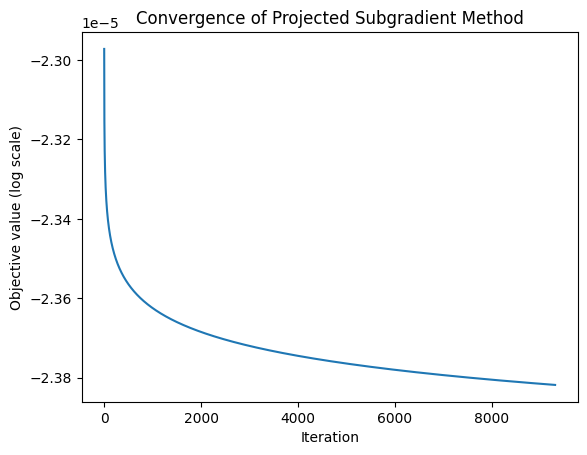

Optimal weights: [0.00210821 0.00217068 0.00212138 0.00216147 0.00217408 0.00215384
 0.00212537 0.00214125 0.00220167 0.00212455 0.00211082 0.00213267
 0.00211457 0.00215057 0.00214655 0.00213907 0.00208063 0.002186
 0.00212788 0.00213945 0.00211151 0.00212627 0.00215228 0.00213238
 0.00212624 0.00212125 0.00223426 0.00215265 0.00215262 0.00209672
 0.00217003 0.00222166 0.00212159 0.00207177 0.00213135 0.00212497
 0.00213982 0.00221763 0.00212766 0.00213736 0.00219012 0.00215693
 0.00216998 0.00201568 0.00203861 0.00212766 0.0021502  0.00213641
 0.00206986 0.00221419 0.0021223  0.00221848 0.00216332 0.00216498
 0.00211859 0.00213719 0.00214788 0.00219841 0.00214003 0.00210593
 0.00212291 0.00221485 0.00216508 0.00204716 0.00214852 0.002132
 0.00212474 0.00212366 0.00213078 0.00213913 0.00218123 0.00209263
 0.00210067 0.00210515 0.00210797 0.00211326 0.00211684 0.00211465
 0.00213105 0.00210611 0.00220184 0.00209782 0.00213604 0.00212766
 0.00216414 0.00212636 0.00211542 0.00208254 0.00

In [37]:
X, mu, Sigma = read_data(verbose=True)
lam = 0.1
c = 0.000001
wprev = np.ones(X.shape[1]) / X.shape[1]

w = projected_subgradient_method(lam, c, Sigma, mu, wprev, tol= 1e-8, plot=True)
print("Optimal weights:", w)
print("Sum of weights:", np.sum(w))
print("Converged objective value:", obj_f_nonSmooth(w, wprev, Sigma, mu, lam, c))

***Proximal gradient method***

In [ ]:
def prox(wprev, step_size, v, c):
    return wprev + sign(v - wprev) * np.maximum(np.abs(v - wprev) - c * step_size, 0)


def proximal_gradient_method(lam, c, Sigma, mu, wprev, L, max_iter=50000, tol= 1e-8, plot=False): 

    w = wprev
    step_size = 1/L
    if plot:
        obj_values = []
    for k in tqdm(range(max_iter)):

        if plot:
            obj_values.append(obj_f_nonSmooth(w, wprev, Sigma, mu, lam, c))

        v = w - step_size * (Sigma @ w - lam * mu)
        u = prox(wprev, step_size, v, c)
        w_new = projection_on_simplex(u)
        # if k == 0:
        #     print("norm(v-w):", np.linalg.norm(v - w))
        #     print("c/L:", c / L)
        #     print("max(|v-w|):", np.max(np.abs(v - w)))
        
        if (np.linalg.norm(w_new - w) < tol) and k > -1000:
            print(f"Converged in {k} iterations.")
            break

        w = w_new

    with open("values_proximal.txt", "w") as f:
        f.write(str(obj_values))
        f.close()


    if plot:
        plt.plot(obj_values)
        plt.xlabel("Iteration")
        
        #plt.yscale("log")
        #plt.yscale('symlog', linthresh=1e-3)
        plt.ylabel("Objective value (log scale)")
        plt.title("Convergence of Proximal Gradient Method")
        plt.show()
    
    return w

    

In [ ]:
#X, mu, Sigma = read_data(verbose=True)
lam = 0.1
c = 0.000001
L = np.linalg.eigvalsh(Sigma).max()
wprev = np.ones(X.shape[1]) / X.shape[1]

w = proximal_gradient_method(lam, c, Sigma, mu, wprev, L, max_iter=50000, tol= 1e-8, plot=True) 
print("Optimal weights:", w)
print("Sum of weights:", np.sum(w))
print("Converged objective value:", obj_f_nonSmooth(w, wprev, Sigma, mu, lam, c))

***Long-Step Path-Following Interior-Point method***

In [ ]:
import jax
import jax.numpy as jnp

def f_mu_jax(x, mu_k, Sigma, mu, lam, c, w_prev):
    n = len(w_prev)
    w = x[:n]
    t = x[n:]

    quad = 0.5 * w @ (Sigma @ w)
    lin  = - lam * (mu @ w)
    l1   = c * jnp.sum(t)

    f_over_mu = (quad + lin + l1) / mu_k

    a = t - (w - w_prev)
    b = t + (w - w_prev)

    barrier = - jnp.sum(jnp.log(w)) \
              - jnp.sum(jnp.log(a)) \
              - jnp.sum(jnp.log(b))

    return f_over_mu + barrier

def f_mu(w, t, mu_k, Sigma, mu, lam, c, w_prev):
    """
    Compute the barrier objective:
        f_mu(w,t) = (1/mu_k) * f(w,t) + barrier(w,t)
    """

    # --- Part 1 : smooth objective f(w,t) / mu_k ---
    quad = 0.5 * w @ (Sigma @ w)          # 1/2 w^T Sigma w
    lin  = - lam * (mu @ w)               # - lambda mu^T w
    l1   = c * np.sum(t)                  # c * sum(t_i)

    f_over_mu = (quad + lin + l1) / mu_k


    # --- Part 2 : barrier terms ---
    # domain terms
    a = t - (w - w_prev)
    b = t + (w - w_prev)

    # barriers
    barrier = - np.sum(np.log(w)) \
              - np.sum(np.log(a)) \
              - np.sum(np.log(b))


    # --- total ---
    return f_over_mu + barrier

def grad_f_mu(w, t, mu_k, Sigma, mu, lam, c, w_prev):

    a = t - (w - w_prev)
    b = t + (w - w_prev)

    grad_w = (Sigma @ w - mu * lam) / mu_k \
             - 1.0/w \
             + 1.0/a \
             - 1.0/b

    grad_t = c / mu * np.ones_like(t) \
             - 1.0/a \
             - 1.0/b

    return np.concatenate([grad_w, grad_t])

def hess_f_mu(w, t, mu_k, Sigma, w_prev):
    n = len(w)

    a = t - (w - w_prev)
    b = t + (w - w_prev)

    # Allocate Hessian
    H = np.zeros((2*n, 2*n))

    # H_ww
    H_ww = Sigma / mu_k
    H_ww = H_ww.copy()
    H_ww += np.diag(1/w**2 + 1/a**2 + 1/b**2)

    # H_tt
    H_tt = np.diag(1/a**2 + 1/b**2)

    # H_wt (diagonal)
    H_wt = np.diag(-1/a**2 + 1/b**2)

    # Fill blocks
    H[:n, :n] = H_ww
    H[n:, n:] = H_tt
    H[:n, n:] = H_wt
    H[n:, :n] = H_wt.T

    return H


def delta(w, t, mu_k, Sigma=Sigma, mu=mu, c=c, w_prev=wprev):
    g = grad_f_mu(w, t, mu_k, Sigma, mu, lam, c, w_prev)
    H = hess_f_mu(w, t, mu_k, Sigma, w_prev)
    v = np.linalg.solve(H, g)
    return np.sqrt(g.T @ v)

def newton_direction(w, t, mu_k, Sigma, mu_vec, lam, c, w_prev):
    """
    Solve KKT system to compute Newton direction (Δw, Δt).
    Constraint: sum(w) = 1.
    """
    n = len(w)

    g = grad_f_mu(w, t, mu_k, Sigma, mu_vec, lam, c, w_prev)
    H = hess_f_mu(w, t, mu_k, Sigma, w_prev)

    
    A = np.zeros((1, 2*n))
    A[0, :n] = 1.0  # sum(w) = 1

    
    KKT = np.block([
        [H,       A.T],
        [A, np.zeros((1,1))]
    ])

    
    rhs = -np.concatenate([g, np.zeros(1)])

    
    sol = np.linalg.solve(KKT, rhs)
    delta_x = sol[:2*n]
    
    dw = delta_x[:n]
    dt = delta_x[n:]

    return dw, dt

def damped_newton_step(w, t, mu_k, Sigma, mu, lam, c, w_prev):

    # 1. Newton direction n(x) = (dw, dt)
    dw, dt = newton_direction(w, t, mu_k, Sigma, mu, lam, c, w_prev)

    delta_x = delta(w, t, mu_k, Sigma, mu, c, w_prev)

    alpha = 1.0 / (1.0 + delta_x)

    w_new = w + alpha * dw
    t_new = t + alpha * dt

    return w_new, t_new

def initialization(w_start, t_start, mu_k, tau, Sigma=Sigma, mu=mu, c=c, w_prev=wprev):
    w = w_start,
    t = t_start
    
    d = delta(w_start, t_start, mu_k, Sigma, mu, c, w_prev)

    while d >= tau:
        w, t = damped_newton_step(w, t, mu_k, Sigma, mu, lam, c, w_prev) 
        d = delta(w, t, mu_k, Sigma, mu, c, w_prev)
    return w_start, t_start

def LS_FP_IPM(lam, tau, c, Sigma, mu, wprev, theta, nu=1, max_iter=50000, tol= 1e-8, plot=False): 


    if plot:
        obj_values = []

    mu_k = 1.0
    w, t = initialization(wprev, np.ones_like(wprev) * 0.1, mu_k, tau, Sigma=Sigma, mu=mu, c=c, w_prev=wprev)
    
    mu_final = tol * (1 - tau) / nu

    k = 1
    while mu_k > mu_final:

        if k >= max_iter:
            print("Maximum number of iterations reached.")
            break

        if plot:
            obj_values.append(obj_f_nonSmooth(w, wprev, Sigma, mu, lam, c))


        mu_k = (1 - theta) * mu_k
        w, t = damped_newton_step(w, t, mu_k, Sigma, mu, lam, c, wprev)
        while delta(w, t, mu_k, Sigma, mu, c, wprev) >= tau:
            w, t = damped_newton_step(w, t, mu_k, Sigma, mu, lam, c, wprev)
        
        k += 1

    # with open("values_proximal.txt", "w") as f:
    #     f.write(str(obj_values))
    #     f.close()
        

    if plot:
        plt.plot(obj_values)
        plt.xlabel("Iteration")
        
        #plt.yscale("log")
        #plt.yscale('symlog', linthresh=1e-3)
        plt.ylabel("Objective value (log scale)")
        plt.title("Convergence of Long-step Path-Follwoing IP Method")
        plt.show()
    
    return w

    

In [ ]:
import numpy as np


# ================================================================
# 1) Objective with barrier
# ================================================================

def f_mu(w, t, mu_k, Sigma, mu, lam, c, w_prev):
    quad = 0.5 * w @ (Sigma @ w)
    lin  = - lam * (mu @ w)
    l1   = c * np.sum(t)

    f_over_mu = (quad + lin + l1) / mu_k

    a = t - (w - w_prev)
    b = t + (w - w_prev)

    barrier = - np.sum(np.log(w)) \
              - np.sum(np.log(a)) \
              - np.sum(np.log(b))

    return f_over_mu + barrier


# ================================================================
# 2) Gradient
# ================================================================

def grad_f_mu(w, t, mu_k, Sigma, mu, lam, c, w_prev):
    a = t - (w - w_prev)
    b = t + (w - w_prev)

    grad_w = (Sigma @ w - mu * lam) / mu_k \
             - 1.0/w \
             + 1.0/a \
             - 1.0/b

    grad_t = (c / mu_k) * np.ones_like(t) \
             - 1.0/a \
             - 1.0/b

    return np.concatenate([grad_w, grad_t])


# ================================================================
# 3) Hessienne
# ================================================================

def hess_f_mu(w, t, mu_k, Sigma, w_prev):
    n = len(w)

    a = t - (w - w_prev)
    b = t + (w - w_prev)

    H = np.zeros((2*n, 2*n))

    # H_ww
    H_ww = Sigma / mu_k
    H_ww = H_ww + np.diag(1/w**2 + 1/a**2 + 1/b**2)

    # H_tt
    H_tt = np.diag(1/a**2 + 1/b**2)

    # H_wt
    H_wt = np.diag(-1/a**2 + 1/b**2)

    H[:n, :n] = H_ww
    H[n:, n:] = H_tt
    H[:n, n:] = H_wt
    H[n:, :n] = H_wt.T

    return H


# ================================================================
# 4) Delta (Newton decrement)
# ================================================================

def delta(w, t, mu_k, Sigma, mu, lam, c, w_prev):
    g = grad_f_mu(w, t, mu_k, Sigma, mu, lam, c, w_prev)
    H = hess_f_mu(w, t, mu_k, Sigma, w_prev)
    v = np.linalg.solve(H, g)
    return np.sqrt(g @ v)


# ================================================================
# 5) Newton direction with KKT
# ================================================================

def newton_direction(w, t, mu_k, Sigma, mu_vec, lam, c, w_prev):
    n = len(w)

    g = grad_f_mu(w, t, mu_k, Sigma, mu_vec, lam, c, w_prev)
    H = hess_f_mu(w, t, mu_k, Sigma, w_prev)

    A = np.zeros((1, 2*n))
    A[0, :n] = 1.0

    KKT = np.block([
        [H, A.T],
        [A, np.zeros((1,1))]
    ])

    rhs = -np.concatenate([g, np.zeros(1)])

    sol = np.linalg.solve(KKT, rhs)
    dx = sol[:2*n]

    dw = dx[:n]
    dt = dx[n:]

    return dw, dt


# ================================================================
# 6) Damped Newton step
# ================================================================

def damped_newton_step(w, t, mu_k, Sigma, mu, lam, c, w_prev):
    dw, dt = newton_direction(w, t, mu_k, Sigma, mu, lam, c, w_prev)
    d = delta(w, t, mu_k, Sigma, mu, lam, c, w_prev)

    alpha = 1.0 / (1.0 + d)

    return w + alpha * dw, t + alpha * dt


# ================================================================
# 7) CORRECTED INITIALIZATION (your bug was here)
# ================================================================

def initialization(w_start, t_start, mu_k, tau, Sigma, mu, lam, c, w_prev):

    # 🔥 CRITICAL FIX: REMOVE THE COMMA!
    w = w_start.copy()
    t = t_start.copy()

    d = delta(w, t, mu_k, Sigma, mu, lam, c, w_prev)
    k = 0
    while d >= tau:
        print(f"Initialization iteration {k}, delta = {d}")
        w, t = damped_newton_step(w, t, mu_k, Sigma, mu, lam, c, w_prev)
        d = delta(w, t, mu_k, Sigma, mu, lam, c, w_prev)
        k += 1
    return w, t


# ================================================================
# 8) Long-step Interior-Point
# ================================================================

def LS_FP_IPM(lam, tau, c, Sigma, mu, wprev, theta,
              nu=1, max_iter=50000, tol=1e-8, plot=False):

    mu_k = 1.0
    # Initial strictly feasible point:
    w_start = np.ones_like(wprev) / len(wprev)
    t_start = np.abs(w_start - wprev) + 1.0

    print("Initializing...")
    w, t = initialization(w_start, t_start, mu_k, tau, Sigma, mu, lam, c, wprev)
    print("Initialization done.")
    mu_final = tol * (1 - tau) / nu

    k = 1

    while mu_k > mu_final:

        if k > max_iter:
            print("Maximum iterations reached.")
            break

        mu_k = (1 - theta) * mu_k
        w, t = damped_newton_step(w, t, mu_k, Sigma, mu, lam, c, wprev)

        # Enforce long-step condition
        while delta(w, t, mu_k, Sigma, mu, lam, c, wprev) >= tau:
            w, t = damped_newton_step(w, t, mu_k, Sigma, mu, lam, c, wprev)

        k += 1
        print(k)

    print(f"Converged in {k} iterations.")
    return w


In [ ]:
#X, mu, Sigma = read_data(verbose=True)
lam = 0.1
c = 0.000001
wprev = np.ones(X.shape[1]) / X.shape[1]
tau = 0.35
theta = 0.15

w = LS_FP_IPM(lam, tau, c, Sigma, mu, wprev, theta, nu=1, max_iter=50000, tol= 1e-8, plot=False) 
print("Optimal weights:", w)
print("Sum of weights:", np.sum(w))
print("Converged objective value:", obj_f_nonSmooth(w, wprev, Sigma, mu, lam, c))